# Known issues

## A float quantity is Iterable
https://docs.python.org/3/library/collections.abc.html#collections.abc.Iterable
This tests if the object has "__iter__"

 - iter(x): on quantity doesn't raise a TypeError just because Quantity has a method called '__getitem__'. Would also if __iter__ was a method
 - np.iterable : (used by matplotlib units interface):
```python 
try:
    iter(y)
except TypeError:
    return False
return True
```
 -  https://docs.python.org/3/library/collections.abc.html#collections.abc.Iterable
 
```
class collections.abc.Iterable¶

    ABC for classes that provide the __iter__() method.

    Checking isinstance(obj, Iterable) detects classes that are registered as Iterable or that have an __iter__() method, but it does not detect classes that iterate with the __getitem__() method. The only reliable way to determine whether an object is iterable is to call iter(obj).

```

In [1]:
import collections
from physipy import m

isinstance(m, collections.abc.Iterable)

import numpy as np
np.iterable(m)

True

As a comparison for the underlying value : 

In [3]:
print(type(m.value))
print(iter(m))

<class 'int'>


TypeError: 'int' object is not iterable

## Array repr with 0 value
Pick best favunit take the smallest when 0 is in the array with positive and negative values :

In [5]:
from physipy import m, Quantity, Dimension
import numpy as np
Quantity(np.array([0, -1.2, 1.2]), Dimension("L"))

<Quantity : [ 0.  -1.2  1.2] m>

# Inplace change using asqarray

In [6]:
from physipy.quantity.utils import asqarray
print(type(m.value))
arrq_9 = np.array([m.__copy__()], dtype=object)
out = asqarray(arrq_9)
# this changes the type of m value
print(type(m.value))

<class 'int'>
<class 'int'>


/Users/mocquin/MYLIB10/MODULES/physipy/physipy/quantity/quantity.py:751: UserWarning: The unit of the quantity is stripped for __array_struct__
  warnings.warn(f"The unit of the quantity is stripped for {item}")


# Numpy trapz implementaion not called when only x or dx is a quantity

Only work when the array to integrate is a quantity. An issue is open at : https://github.com/numpy/numpy/issues/18902.

In [7]:
from physipy import m
import numpy as np

In [9]:
# this works
print(np.trapz(np.arange(5)*m))
# also this
print(np.trapz(np.arange(5), x=np.arange(5)*m))
print(np.trapz(np.arange(5), dx=5000*m, x=np.arange(5)*m)) #dx is silent
# but not this
# np.trapz(np.arange(5), dx=5000*m)
print("----uncomment above line to trigger exception")

8.0 m
8.0 m
8.0 m
----uncomment above line to trigger exception


# Array function interface not triggered on scalars

Calling a numpy function with only scalars will not trigger the array function interface, since it is used only when an argument is an array.

In [10]:
from physipy import m
# this raises a DimensionError because of the casting into float
#np.random.normal(3*m, 1*m)
# while this works
np.random.normal(np.array(3*m), np.array(1*m))

2.8596446816520693

# HALF-FIXED (Matplotlib histogram) by adding "to_numpy" method, but we loose the unit

It turns out that matplotlib first checks if the object has a "to_numpy()" method, then again improved by removing to_numpy and removing __iter__ and delegate it to getattr

Some preprocessing turn a quantity-array into a "set of elements", and plots one histogram for each value.

In [11]:
import numpy as np
from physipy import m
import matplotlib.pyplot as plt

In [12]:
arr = np.random.normal(1, 0.1, size=100)*m
arr

<Quantity : [0.77510028 1.02692688 0.82458667 0.98335836 0.91954635 0.93200141
 1.06254089 1.10455135 1.09023741 1.10103177 1.026317   0.83093738
 0.94099114 1.1534862  1.0606804  1.1023009  1.12974713 1.15801316
 0.98731712 1.06882969 0.97161314 0.86352201 0.89182966 0.8768534
 0.8994358  1.02498588 1.02672016 0.96845546 1.12534779 1.00561238
 1.02279429 1.07056477 0.9492133  0.91274716 1.05048081 0.96627151
 1.02669064 0.83189018 0.96324937 1.13060259 0.90266738 1.15438202
 0.80017485 1.16467932 0.98770121 0.95927471 0.97653359 1.02132051
 1.23089246 0.93924862 0.82258946 0.95622603 1.00342641 0.86344481
 0.99243329 0.91230646 0.99573178 1.08633306 1.19398477 1.0215252
 1.11952956 1.05683548 0.88520692 1.01250757 1.05161642 0.99664025
 1.11138056 1.10748649 1.16659512 1.02593404 0.85926943 0.98001556
 0.97229262 1.06992373 1.01969076 1.09705661 0.90186104 1.04536702
 1.14499949 0.76019103 1.03807758 1.03676373 1.01122003 0.98969461
 1.1362876  1.13061323 0.83437231 0.88020199 0.98266

/Users/mocquin/MYLIB10/MODULES/physipy/physipy/quantity/quantity.py:751: UserWarning: The unit of the quantity is stripped for __array_struct__
  warnings.warn(f"The unit of the quantity is stripped for {item}")


(array([ 3.,  5.,  9.,  8., 18., 21., 12., 14.,  7.,  3.]),
 array([0.76019103, 0.80726117, 0.85433132, 0.90140146, 0.9484716 ,
        0.99554174, 1.04261189, 1.08968203, 1.13675217, 1.18382231,
        1.23089246]),
 <BarContainer object of 10 artists>)

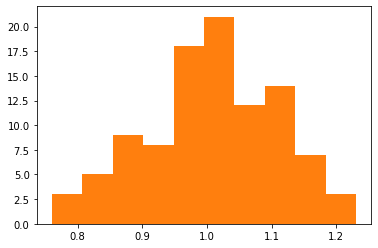

In [13]:
plt.hist(arr.value)
plt.hist(arr)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

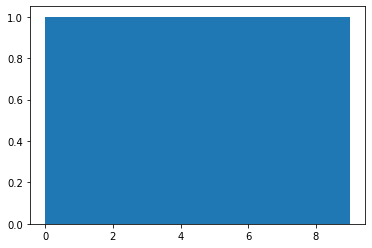

In [14]:
plt.hist(np.arange(10)*m)

# Matplotlib histogram, again : missing units support

Source code for hist : https://matplotlib.org/stable/_modules/matplotlib/axes/_axes.html#Axes.hist

One of the first things done is : 
```python
x = cbook._reshape_2D(x, 'x')
```
With 
```python
Signature: cbook._reshape_2D(X, name)
Source:   
def _reshape_2D(X, name):
    """
    Use Fortran ordering to convert ndarrays and lists of iterables to lists of
    1D arrays.

    Lists of iterables are converted by applying `np.asanyarray` to each of
    their elements.  1D ndarrays are returned in a singleton list containing
    them.  2D ndarrays are converted to the list of their *columns*.

    *name* is used to generate the error message for invalid inputs.
    """

    # unpack if we have a values or to_numpy method.
    try:
        X = X.to_numpy()
    except AttributeError:
        try:
            if isinstance(X.values, np.ndarray):
                X = X.values
        except AttributeError:
            pass

    # Iterate over columns for ndarrays.
    if isinstance(X, np.ndarray):
        X = X.T

        if len(X) == 0:
            return [[]]
        elif X.ndim == 1 and np.ndim(X[0]) == 0:
            # 1D array of scalars: directly return it.
            return [X]
        elif X.ndim in [1, 2]:
            # 2D array, or 1D array of iterables: flatten them first.
            return [np.reshape(x, -1) for x in X]
        else:
            raise ValueError(f'{name} must have 2 or fewer dimensions')

    # Iterate over list of iterables.
    if len(X) == 0:
        return [[]]

    result = []
    is_1d = True
    for xi in X:
        # check if this is iterable, except for strings which we
        # treat as singletons.
        if (isinstance(xi, collections.abc.Iterable) and
                not isinstance(xi, str)):
            is_1d = False
        xi = np.asanyarray(xi)
        nd = np.ndim(xi)
        if nd > 1:
            raise ValueError(f'{name} must have 2 or fewer dimensions')
        result.append(xi.reshape(-1))

    if is_1d:
        # 1D array of scalars: directly return it.
        return [np.reshape(result, -1)]
    else:
        # 2D array, or 1D array of iterables: use flattened version.
        return result
```

In [11]:
import matplotlib.pyplot as plt
from physipy import units, m, K, setup_matplotlib
from matplotlib import cbook
import numpy as np

In [12]:
arr = np.random.normal(1, 0.1, size=100)*m
setup_matplotlib()

(array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],


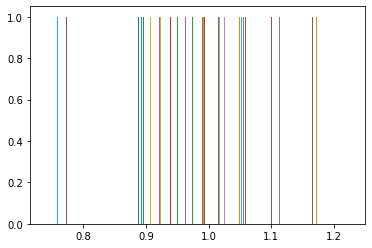

In [13]:
plt.hist(arr)

I created a [unit package for physical computation](https://github.com/mocquin/physipy) and its [matplotlib' unit interface](https://github.com/mocquin/physipy/blob/master/physipy/quantity/plot.py) that works well for plotting with `Axes` methods like `ax.plot`, as you can see in the [plotting notebooke demo](https://github.com/mocquin/physipy/blob/master/docs/Plotting.ipynb).
The issue I am facing is to have the unit interface work with the histogram plotting, like in `ax.hist(arr)`.

For now, I have 2 solutions that are not satisfiying : 
 - first solution is the current state of my project : I added to my `Quantity` object a `to_numpy()` method that cast the instance into a plain numpy array, which makes the histogram plotting work, but looses the automatic unit plotting, since it is not a Quantity anymore but a plain numpy array. For some reasons, this method is never used when plotting with `ax.plot`, but is one of the first things tried when using `ax.hist`.
 - other solution is what I had until recently, which was even worse : without the `to_numpy()` method, matplotlib tries to loop inside the object, and since my object can be iterated over (if it is a 1D array for eg), then it plots one 1-element-histogram for each value. You can see what it looked like [here](https://render.githubusercontent.com/view/ipynb?color_mode=light&commit=f0871009f57da092eee1d640d9508070d1662c1d&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d6f637175696e2f706879736970792f663038373130303966353764613039326565653164363430643935303830373064313636326331642f646f63732f4b6e6f776e2532304973737565732e6970796e62&nwo=mocquin%2Fphysipy&path=docs%2FKnown+Issues.ipynb&repository_id=175999533&repository_type=Repository#Matplotlib-histogram) (see the Matplotlib histogram section).

After digging into the source code, I found that some preprocessing is done the object passed to `hist`, using [cbook._reshape2d](https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/axes/_axes.py#L6654). Then, onto [`cbook._reshape2D` source](https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/cbook/__init__.py#L1304), I think most of the time objects are subclass of `np.ndarray`, and so are caught [in this loop](https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/cbook/__init__.py#L1327). But my class is not a subclass of `np.ndarray`, so it ends up [in this loop](https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/cbook/__init__.py#L1347). Then `np.asanyarray(xi)` is called and cast each quantity element (like `1m` into just `1`) into an int/float, again loosing the unit. Now the workaround for this kind of problem is currently addressed by numpy's [NEP-35](https://numpy.org/neps/nep-0035-array-creation-dispatch-with-array-function.html), which allows to override array-creation functions (like `np.asanyarray`), but it requires to pass an extra argument : `np.asanyarray(x)` would be `np.asanyarray(x, like=x)`. Unfortunately, this doesn't solve completely the problem, because the `xi` object are reshaped using `xi.reshape` and not `np.reshape(xi)`.

In [4]:
import collections
import numpy as np
from physipy import m

# make a 1D array of meters
X = np.arange(10)*m

# introspect https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/cbook/__init__.py#L1347 
result = []
is_1d = True
for xi in X:
    # check if this is iterable, except for strings which we
    # treat as singletons.
    if (isinstance(xi, collections.abc.Iterable) and
             not isinstance(xi, str)):
        is_1d = False
    #xi = np.asanyarray(xi)
    print(xi)
    xi = np.asanyarray(xi, like=xi)
    nd = np.ndim(xi)
    print(xi.reshape(-1))
    if nd > 1:
        raise ValueError(f'{name} must have 2 or fewer dimensions')
    result.append(xi.reshape(-1))

print(is_1d)
if is_1d:
    # 1D array of scalars: directly return it.
    #return 
    print([np.reshape(result, -1)])
else:
    # 2D array, or 1D array of iterables: use flattened version.
    #return 
    print(result)

0 m
[0] m
1 m
[1] m
2 m
[2] m
3 m
[3] m
4 m
[4] m
5 m
[5] m
6 m
[6] m
7 m
[7] m
8 m
[8] m
9 m
[9] m
True
[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]


# Numpy random normal

Not really a bug, more of a Feature request on numpy's side...
`__array_struct__` is tried on the value, and unit is dropped.

See https://github.com/numpy/numpy/issues/19382

In [1]:
import numpy as np
from physipy import m

In [2]:
np.random.normal(np.array([1, 2, 3]),
                 np.array([2, 3, 4]), size=(2, 3))

array([[-1.577376  ,  2.99188189,  5.0140872 ],
       [ 2.91279438,  0.05503252,  1.24377635]])

In [3]:
np.random.normal(np.array([1, 2, 3])*m,
                 np.array([2, 3, 4])*m, size=(2, 3))

getattr __array_struct__
getattr __array_struct__


/Users/mocquin/MYLIB10/MODULES/physipy/physipy/quantity/quantity.py:708: UserWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.")


array([[ 4.98089529,  3.21840818,  4.51290955],
       [ 3.09490679,  0.56733076, -0.65881607]])

In [14]:
import numpy as np
np.random.seed(1234)

HANDLED_FUNCTIONS = {}

class NumericalLabeled():
    def __init__(self, value, label=""):
        self.value = value
        self.label = label
        
    def __repr__(self):
        return "NumericalLabelled<"+str(self.value) + "," + self.label+">"
    
    def __array_function__(self, func, types, args, kwargs):
        if func not in HANDLED_FUNCTIONS:
            return NotImplemented
        return HANDLED_FUNCTIONS[func](*args, **kwargs)
    

def make_numericallabelled(x, label=""):
    """
    Helper function to cast anything into a NumericalLabelled object.
    """
    if isinstance(x, NumericalLabeled):
        return x
    else:
        return NumericalLabeled(x, label=label)
    
# Numpy functions            
# Override functions - used with __array_function__
def implements(np_function):
    def decorator(func):
        HANDLED_FUNCTIONS[np_function] = func
        return func
    return decorator    
    

@implements(np.random.normal)
def np_random_normal(loc=0.0, scale=1.0, **kwargs):
    # cast both loc and scale into Numericallabelled
    loc = make_numericallabelled(loc)
    scale = make_numericallabelled(scale)
    # check their label is "compatible"
    if not loc.label == scale.label:
        raise ValueError
    return NumericalLabeled(np.random.rand(loc=loc.value,
                                           scale=scale.value, **kwargs), 
                            loc.label+scale.label)

@implements(np.mean)
def np_mean(a, *args, **kwargs):
    return NumericalLabeled(np.mean(a.value, *args, **kwargs),
                            a.label)



def main():
    # reference result for standard array
    arr = np.arange(10)
    print(np.mean(arr))
    print(np.random.normal(arr))
    
    # array-like object
    num_labeled = NumericalLabeled(arr, "toto")
    print(np.mean(num_labeled))
    try:
        print(np.random.normal(num_labeled))
    except Exception as e:
        print(e)

main()

4.5
[ 0.47143516 -0.19097569  3.43270697  2.6873481   3.27941127  5.88716294
  6.85958841  6.3634765   8.01569637  6.75731505]
NumericalLabelled<4.5,toto>
float() argument must be a string or a number, not 'NumericalLabeled'


In [18]:
import sys
print("Python :", sys.version)
print("Numpy :", np.__version__)

Python : 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
Numpy : 1.21.0


In [8]:
arr = np.arange(10)

# Reference result 
print(np.mean(arr))
print(np.random.normal(arr))

custom_obj = MyArrayLike(arr)
print(np.mean(custom_obj))           # np.mean will trigger __array_function__ interface
print(np.random.normal(custom_obj))  # np.random.normal will "only" try to cast the object to float

4.5
[-1.00485143  0.78212753 -0.28082594  5.86408205  5.1756093   4.76436004
  6.2488786   7.5691081   9.0461194   9.04187251]


NameError: name 'MyArrayLike' is not defined

# Power of dimension are not casted to int when possible

In [1]:
from physipy import m, K

In [4]:
a = (m**2)**0.5
a.dimension

<Dimension : {'L': 1.0, 'M': 0.0, 'T': 0.0, 'I': 0.0, 'theta': 0.0, 'N': 0.0, 'J': 0.0, 'RAD': 0.0, 'SR': 0.0}>

# Degree rendering

Degree as favunit is rendered as "<function deg at 0x...>"

In [19]:
from physipy import rad, units
deg = units["deg"]
a = 5*deg
a.favunit = deg
a

<Quantity : 0.08726646259971647 rad, symbol=deg*UndefinedSymbol>

# Numpy full not triggered by array_function interface

Get `TypeError: no implementation found for 'numpy.full' on types that implement __array_function__: [<class 'physipy.quantity.quantity.Quantity'>]`
while it is implemented, so it seems its not triggered.

This is a numpy bug : https://github.com/numpy/numpy/issues/21033

In [3]:
from physipy import m
import numpy as np

np.full(3, m, like=m)

TypeError: no implementation found for 'numpy.full' on types that implement __array_function__: [<class 'physipy.quantity.quantity.Quantity'>]

# Presence of "%" symbol in favunit

In [84]:
from physipy import K
import sympy as sp
pc = 1/K
pc.symbol = "%/K"

q = 2*pc
q.favunit = pc

In [85]:
pc.symbol

'%/K'

In [86]:
complemented = q._compute_complement_value().encode('unicode-escape').decode()
complemented

'%/K'

In [103]:
a = sp.Symbol("a")
b = sp.physics.units.percent #sp.Symbol("%")

In [104]:
a/b

a/percent

In [97]:
((percent_transformer,) + standard_transformations )

(<function __main__.percent_transformer(tokens, local_dict, global_dict)>,
 <function sympy.parsing.sympy_parser.lambda_notation(tokens, local_dict, global_dict)>,
 <function sympy.parsing.sympy_parser.auto_symbol(tokens, local_dict, global_dict)>,
 <function sympy.parsing.sympy_parser.repeated_decimals(tokens, local_dict, global_dict)>,
 <function sympy.parsing.sympy_parser.auto_number(tokens, local_dict, global_dict)>,
 <function sympy.parsing.sympy_parser.factorial_notation(tokens, local_dict, global_dict)>)

In [100]:
import sympy as sp
from sympy.parsing.sympy_parser import standard_transformations 

def percent_transformer(tokens, local_dict, global_dict):
    return [tok if tok != "%" else  sp.physics.units.percent for tok in tokens]

sp.parsing.sympy_parser.parse_expr("%/K", transformations=((percent_transformer,) + standard_transformations))

In [87]:
sp.parsing.sympy_parser.parse_expr(complemented,
                                   local_dict={"%":sp.physics.units.percent},
                                   #evaluate=False, 
                              )

SyntaxError: invalid syntax (<string>, line 1)

percent